<a href="https://colab.research.google.com/github/AndyYFTao/HK-Property-Prices-TSA/blob/main/HK_Property_Prices_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import numpy as np                               
import pandas as pd                              
import matplotlib.pyplot as plt                  
import seaborn as sns                            

from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize              

import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import scipy.stats as scs
import scipy.special as sps
import math

from itertools import product                    
from tqdm import tqdm_notebook

%matplotlib inline
np.random.seed(2021)

import warnings                                  
warnings.filterwarnings('ignore')

In [21]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## I. Data Visualization

**Real Residential Property Prices for Hong Kong** <br>
Index 2010=100, Quarterly, Not Seasonally Adjusted

Sources: National sources, BIS Residential Property Price database, http://www.bis.org/statistics/pp.htm


In [3]:
price = pd.read_csv('QHKR628BIS.csv', index_col=['DATE'], parse_dates=['DATE'])
price.head()

,QHKR628BIS
DATE,
1979-10-01,46.8504
1980-01-01,49.5886
1980-04-01,48.8247
1980-07-01,51.9333
1980-10-01,56.2182


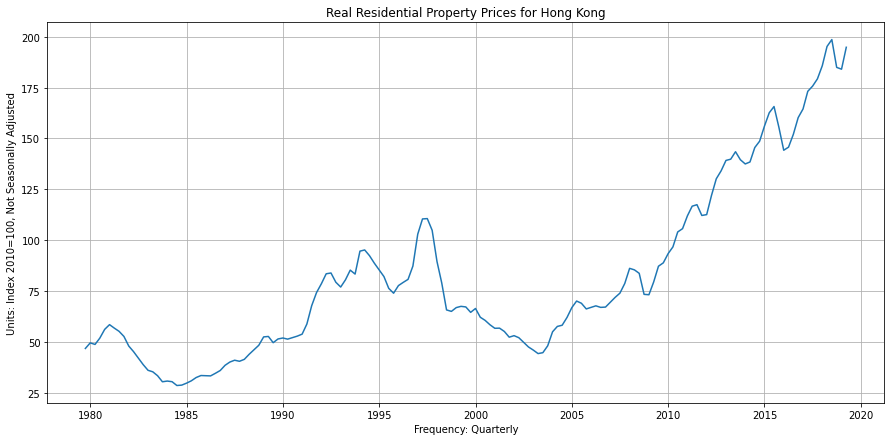

In [4]:
# leave out the last 5 values for forecasting later
pp_ori = price[:-5].QHKR628BIS

plt.figure(figsize=(15, 7))
plt.plot(pp_ori)
plt.title('Real Residential Property Prices for Hong Kong')
plt.grid(True)
plt.xlabel("Frequency: Quarterly")
plt.ylabel("Units: Index 2010=100, Not Seasonally Adjusted")
plt.show()

### I-1. Box-Cox Transformation
To address potential non-stationarity in variance, we perform Box-Cox transformation, which contains Log transformation as a special case.

In [22]:
fitted_series, fitted_lambda = scs.boxcox(pp_ori.values)
pp = pd.Series(fitted_series, index=pp_ori.index)
# Later to be transformed back by sps.inv_boxcox(pp, fitted_lambda)

In [23]:
# Plot time series, its ACF and PACF, calculate Augmented Dickey-Fuller unit root test
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Plot\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

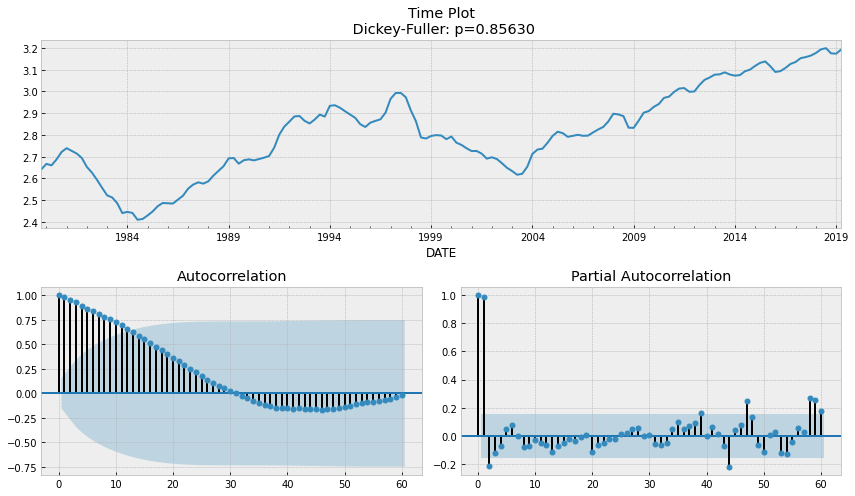

In [8]:
tsplot(pp, lags=60)

## II. Box-Jenkins Method

### II-1. Non-seasonal Models

The ACF before any differencing decays slowly and the Augmented Dickey-Fuller test does not reject the null hypothesis. We need to take a first difference of the data.

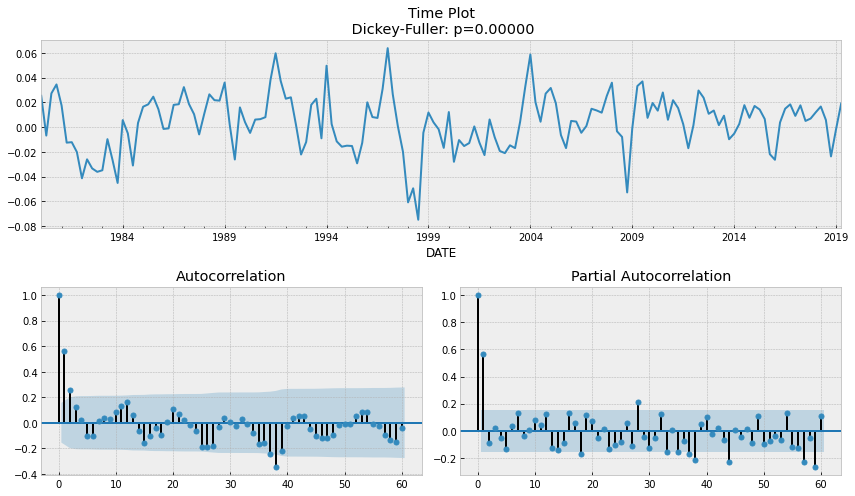

In [9]:
pp_d1 = (pp - pp.shift(1)).dropna(inplace=False)
tsplot(pp_d1, lags=60)

The null hypothesis in the Augmented Dickey-Fuller test is rejected. Hence it can be regarded as stationary.

#### II-1-a. Model Specification
We tentatively add $ARIMA(1,1,1)$ and $ARIMA(1,1,2)$ as our candidates according to the sample ACF & PACF above. See a Summary of rules for identifying ARIMA models [here](https://people.duke.edu/~rnau/arimrule.htm)



#### II-1-b. Parameter Estimation

In [10]:
param = (1, 1, 1) # ARIMA(1,1,1)
model_fit = ARIMA(pp, order=param).fit(method='css-mle')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  158
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 407.108
Method:                       css-mle   S.D. of innovations              0.018
Date:                Mon, 03 May 2021   AIC                           -806.217
Time:                        12:41:37   BIC                           -793.966
Sample:                    01-01-1980   HQIC                          -801.242
                         - 04-01-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.003      1.223      0.223      -0.002       0.010
ar.L1.D.y      0.4418      0.125      3.540      0.001       0.197       0.686
ma.L1.D.y      0.1821      0.139      1.314      0.191      -0.090       0.454
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.2633           +0.0000j            2.2633            0.0000
MA.1           -5.4911           +0.0000j            5.4911            0.5000
-----------------------------------------------------------------------------
"""

In [11]:
param = (1, 1, 2) # ARIMA(1,1,2)
model_fit = ARIMA(pp, order=param).fit(method='css-mle')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  158
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 407.117
Method:                       css-mle   S.D. of innovations              0.018
Date:                Mon, 03 May 2021   AIC                           -804.234
Time:                        12:41:37   BIC                           -788.921
Sample:                    01-01-1980   HQIC                          -798.015
                         - 04-01-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.003      1.212      0.227      -0.002       0.010
ar.L1.D.y      0.4700      0.241      1.947      0.053      -0.003       0.943
ma.L1.D.y      0.1530      0.255      0.600      0.549      -0.347       0.653
ma.L2.D.y     -0.0199      0.152     -0.131      0.896      -0.317       0.277
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.1274           +0.0000j            2.1274            0.0000
MA.1           -4.2193           +0.0000j            4.2193            0.5000
MA.2           11.9017           +0.0000j           11.9017            0.0000
-----------------------------------------------------------------------------
"""

Since the MA coefficients are relatively less significant, we also try $ARIMA(1,1,0)$ and find it simpler & with lower AIC.

In [12]:
param = (1, 1, 0) # ARIMA(1,1,0)
model_fit = ARIMA(pp, order=param).fit(method='css-mle')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  158
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 406.307
Method:                       css-mle   S.D. of innovations              0.018
Date:                Mon, 03 May 2021   AIC                           -806.614
Time:                        12:41:37   BIC                           -797.426
Sample:                    01-01-1980   HQIC                          -802.883
                         - 04-01-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.003      1.133      0.259      -0.003       0.010
ar.L1.D.y      0.5639      0.066      8.602      0.000       0.435       0.692
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7735           +0.0000j            1.7735            0.0000
-----------------------------------------------------------------------------
"""

#### II-1-c. Model Diagnostics
Since as of today, the package ARIMA does not contain a one liner `plot_diagnostics()` as `SARIMAX` does, we need to implement it from scratch here.

In [13]:
def internally_studentized_residual(X,Y):
    X = np.array(X, dtype=float)
    Y = np.array(Y, dtype=float)
    mean_X = np.mean(X)
    mean_Y = np.mean(Y)
    n = len(X)
    diff_mean_sqr = np.dot((X - mean_X), (X - mean_X))
    beta1 = np.dot((X - mean_X), (Y - mean_Y)) / diff_mean_sqr
    beta0 = mean_Y - beta1 * mean_X
    y_hat = beta0 + beta1 * X
    residuals = Y - y_hat
    h_ii = (X - mean_X) ** 2 / diff_mean_sqr + (1 / n)
    Var_e = math.sqrt(sum((Y - y_hat) ** 2)/(n-2))
    SE_regression = Var_e*((1-h_ii) ** 0.5)
    studentized_residuals = residuals/SE_regression
    return studentized_residuals

def plot_diagnostics(resid, lags=10, fig=None, figsize=None):
    """
    Parameters
    ----------
    resid: results from model_fit.resid
    lags : int, optional
        Number of lags to include in the correlogram. Default is 10.
    fig : Figure, optional
        If given, subplots are created in this figure instead of in a new
        figure. Note that the 2x2 grid will be created in the provided
        figure using `fig.add_subplot()`.
    figsize : tuple, optional
        If a figure is created, this argument allows specifying a size.
        The tuple is (width, height).

    Returns
    -------
    Figure
        Figure instance with diagnostic plots

    Notes
    -----
    Produces a 2x2 plot grid with the following plots (ordered clockwise
    from top left):

    1. Standardized residuals over time
    2. Histogram plus estimated density of standardized residuals, along
        with a Normal(0,1) density plotted for reference.
    3. Normal Q-Q plot, with Normal reference line.
    4. Correlogram
    """
    from statsmodels.graphics.utils import _import_mpl, create_mpl_fig
    _import_mpl()
    fig = create_mpl_fig(fig, figsize)

    # Standardized residuals
    ix = resid.index

    # Top-left: residuals vs time
    ax = fig.add_subplot(221)
    resid.dropna().plot(ax=ax)
    ax.hlines(0, ix[0], ix[-1], alpha=0.5)
    ax.set_xlim(ix[0], ix[-1])
    ax.set_xlabel('')
    ax.set_title(f'Standardized residual')

    # Top-right: histogram, Gaussian kernel density, Normal density
    # Can only do histogram and Gaussian kernel density on the non-null
    # elements
    resid_nonmissing = resid.dropna()
    ax = fig.add_subplot(222)

    # gh5792: Remove  except after support for matplotlib>2.1 required
    try:
        ax.hist(resid_nonmissing, density=True, label='Hist')
    except AttributeError:
        ax.hist(resid_nonmissing, normed=True, label='Hist')

    from scipy.stats import gaussian_kde, norm
    kde = gaussian_kde(resid_nonmissing)
    xlim = (-1.96*2, 1.96*2)
    x = np.linspace(xlim[0], xlim[1])
    ax.plot(x, kde(x), label='KDE')
    ax.plot(x, norm.pdf(x), label='N(0,1)')
    ax.set_xlim(xlim)
    ax.legend()
    ax.set_title('Histogram plus estimated density')

    # Bottom-left: QQ plot
    ax = fig.add_subplot(223)
    from statsmodels.graphics.gofplots import qqplot
    qqplot(resid_nonmissing, line='s', ax=ax)
    ax.set_title('Normal Q-Q')

    # Bottom-right: Correlogram
    ax = fig.add_subplot(224)
    from statsmodels.graphics.tsaplots import plot_acf
    plot_acf(resid, ax=ax, lags=lags)
    ax.set_title('Correlogram')

    ax.set_ylim(-1, 1)

    return fig

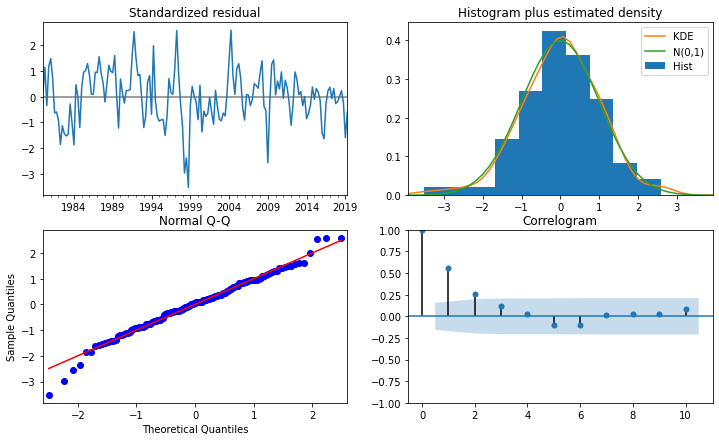

In [14]:
# Diagnostics for ARIMA(1,1,0)
model_fitted_y = model_fit.fittedvalues
resid_studentized = internally_studentized_residual(pp[1:],model_fitted_y)
resid_studentized = pd.Series(resid_studentized, index=model_fitted_y.index)
plot_diagnostics(resid_studentized, figsize=(12,7))
plt.show()

In [15]:
# Shapiro-Wilk Normality Test
shapiro_test = scs.shapiro(model_fit.resid)
print("Test statistics: {:.4f}".format(shapiro_test[0]))
print("P-value: {:.4f}".format(shapiro_test[1]))

Test statistics: 0.9961
P-value: 0.9538


In [16]:
# Ljung-Box Test
no_lags = 10
critical_val = 0.05
lb_stat, pval = sm.stats.acorr_ljungbox(model_fit.resid, lags=no_lags)
lb_res = pd.DataFrame({"lb_stat": lb_stat, "lb_pvalue": pval}, index=np.arange(1, no_lags + 1))
lb_res["Sig?"] = lb_res['lb_pvalue'] < critical_val
lb_res

,lb_stat,lb_pvalue,Sig?
1,0.425562,0.514175,False
2,1.186820,0.552440,False
3,1.187428,0.756021,False
4,1.305787,0.860393,False
5,4.037228,0.544069,False
6,6.683612,0.351100,False
7,7.942562,0.337686,False
8,8.092873,0.424451,False
9,8.408275,0.493582,False
10,8.659473,0.564697,False


The normality is confirmed and Ljung-Box test shows that the residuals are not correlated despite the minor violations in the Correlogram.

#### II-1-d. Analysis of Over-parameterized Models
Incrementing MA parameters has been shown to be inferior in previous steps, here we increment AR parameters instead.

In [17]:
param = (2, 1, 0) # ARIMA(2,1,0)
model_fit = ARIMA(pp, order=param).fit(method='css-mle')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  158
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 407.048
Method:                       css-mle   S.D. of innovations              0.018
Date:                Mon, 03 May 2021   AIC                           -806.096
Time:                        12:41:38   BIC                           -793.846
Sample:                    01-01-1980   HQIC                          -801.121
                         - 04-01-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.003      1.234      0.219      -0.002       0.010
ar.L1.D.y      0.6197      0.080      7.776      0.000       0.463       0.776
ar.L2.D.y     -0.0971      0.080     -1.220      0.224      -0.253       0.059
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.1916           -0.3388j            3.2095           -0.0168
AR.2            3.1916           +0.3388j            3.2095            0.0168
-----------------------------------------------------------------------------
"""

The coefficient of the incremented term turns out to be insignificant and close to zero. Hence we settle down on the $ARIMA(1,1,0)$ model for non-seasonal candidates.

### II-2. Seasonal Models

Observe that the sample ACF shows potential seasonality. So we take the seasonal difference with s = 4 after taking the first common difference since the data are collected quarterly.

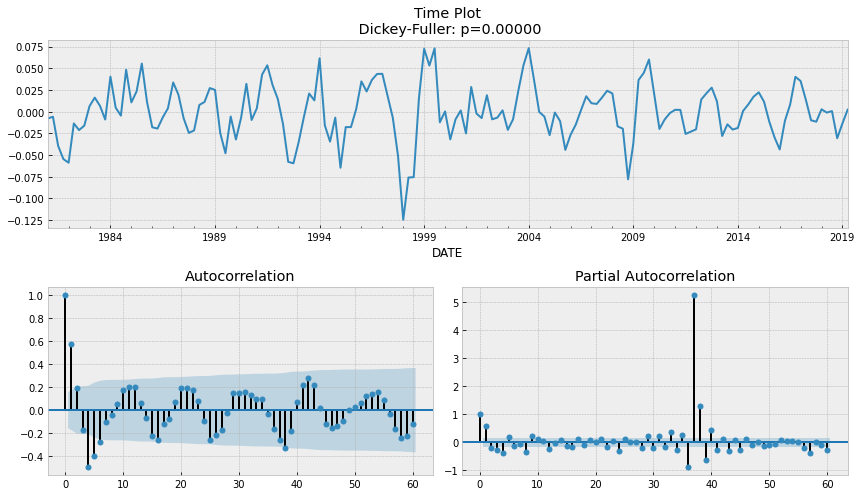

In [18]:
pp_d1_s4 = (pp_d1 - pp_d1.shift(4)).dropna(inplace=False)
tsplot(pp_d1_s4, lags=60)

#### II-2-a. Model Specification
Here the null hypothesis in the Augmented Dickey-Fuller test is rejected, too. 


By the principle of parsimony, we proceed with a *seasonal* $ARIMA(0,1,1)\times(0,1,1)_4$ model


*  d  equals 1 because we had first common differencing
*  D  equals 1 because we had first seasonal differencing
*  q  equals 1 as seen on the ACF
*  Q  equals 1 since the 4-th lag on ACF is significant
*  p & P are kept to be 0 to control the model complexity. They could be incremented as needed if the model turns out to be inadequate.



In [19]:
param = (0, 1, 0, 1) # parameters_list - (p, q, P, Q) tuples
d, D = 1, 1
s = 4

#### II-2-b. Parameter Estimation

In [20]:
model_fit = sm.tsa.statespace.SARIMAX(pp, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  159
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood                 387.909
Date:                           Mon, 03 May 2021   AIC                           -769.819
Time:                                   12:41:40   BIC                           -760.708
Sample:                               10-01-1979   HQIC                          -766.118
                                    - 04-01-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5563      0.066      8.366      0.000       0.426       0.687
ma.S.L4       -0.9788      0.161     -6.097      0.000      -1.293      -0.664
sigma2         0.0003    6.3e-05      5.547      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       75.62   Jarque-Bera (JB):                11.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.49
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### II-2-c. Model Diagnostics

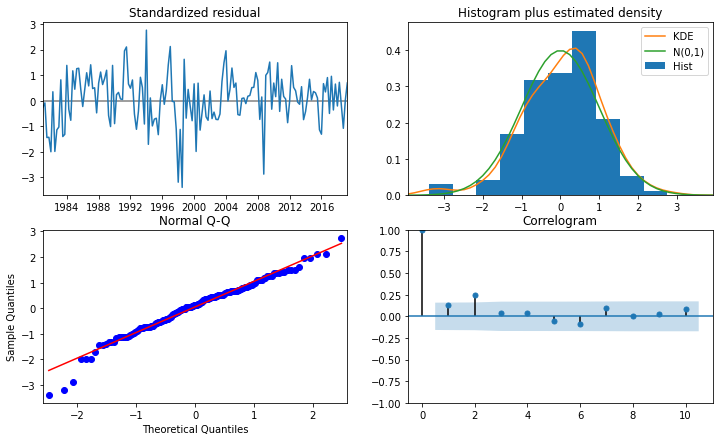

In [21]:
model_fit.plot_diagnostics(figsize=(12,7))
plt.show()

The **ideal situations** should be as follows:

**Top left**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

**Top Right**: The density plot suggest normal distribution with mean zero.

**Bottom left**: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

**Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

**Here**, the residual errors don't seem to have a constant variance (where volatility clustering exists) and its distribution is not perfectly normal. We further conduct two tests: Shapiro-Wilk Normality Test & Ljung-Box Test.

In [22]:
# Shapiro-Wilk Normality Test
shapiro_test = scs.shapiro(model_fit.resid)
print("Test statistics: {:.4f}".format(shapiro_test[0]))
print("P-value: {:.4f}".format(shapiro_test[1]))

Test statistics: 0.1471
P-value: 0.0000


Hence, we reject the normal hypothesis. This questions the assumptions of the model.

In [23]:
# Ljung-Box Test
no_lags = 10
critical_val = 0.05
lb_stat, pval = sm.stats.acorr_ljungbox(model_fit.resid, lags=no_lags)
lb_res = pd.DataFrame({"lb_stat": lb_stat, "lb_pvalue": pval}, index=np.arange(1, no_lags + 1))
lb_res["Sig?"] = lb_res['lb_pvalue'] < critical_val
lb_res

,lb_stat,lb_pvalue,Sig?
1,0.008116,0.928216,False
2,0.009034,0.995493,False
3,0.032191,0.998479,False
4,24.432168,0.000065,True
5,24.434883,0.000179,True
6,24.436196,0.000434,True
7,24.439480,0.000953,True
8,24.450243,0.001925,True
9,24.471360,0.003615,True
10,24.471364,0.006443,True


Correlation checking for residuals:
*  Individually: the correlogram (i.e. the sample autocorrelation function of residuals) shows that a few lags stand out of the Bartlett's bounds.
*  Jointly: the Ljung-Box test shows that for all $4 \leq K \leq 10$ the result is significant. Recall that the null hypothesis in this test is that the error terms have no correlation. <br>

We proceed to consider more sophisticated models, such as $ARIMA(0,1,2)×(0,1,1)_4$ and $ARIMA(1,1,1)×(0,1,1)_4$

In [24]:
# seasonal ARIMA(0,1,2)×(0,1,1)_4
param = (0, 2, 0, 1) 
d, D = 1, 1
s = 4

model_fit = sm.tsa.statespace.SARIMAX(pp, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  159
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 4)   Log Likelihood                 391.813
Date:                           Mon, 03 May 2021   AIC                           -775.626
Time:                                   12:41:42   BIC                           -763.478
Sample:                               10-01-1979   HQIC                          -770.692
                                    - 04-01-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6317      0.071      8.953      0.000       0.493       0.770
ma.L2          0.2225      0.074      3.010      0.003       0.078       0.367
ma.S.L4       -0.9643      0.104     -9.246      0.000      -1.169      -0.760
sigma2         0.0003   4.82e-05      6.997      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       57.65   Jarque-Bera (JB):                 5.74
Prob(Q):                              0.03   Prob(JB):                         0.06
Heteroskedasticity (H):               0.58   Skew:                            -0.31
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
# seasonal ARIMA(1,1,1)×(0,1,1)_4
param = (1, 1, 0, 1) 
d, D = 1, 1
s = 4

model_fit = sm.tsa.statespace.SARIMAX(pp, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  159
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 4)   Log Likelihood                 392.136
Date:                           Mon, 03 May 2021   AIC                           -776.273
Time:                                   12:41:42   BIC                           -764.125
Sample:                               10-01-1979   HQIC                          -771.339
                                    - 04-01-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5545      0.094      5.890      0.000       0.370       0.739
ma.L1          0.1786      0.110      1.620      0.105      -0.038       0.395
ma.S.L4       -0.9011      0.066    -13.551      0.000      -1.031      -0.771
sigma2         0.0003   4.21e-05      8.160      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       52.66   Jarque-Bera (JB):                 2.29
Prob(Q):                              0.09   Prob(JB):                         0.32
Heteroskedasticity (H):               0.63   Skew:                            -0.10
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Comparing these two, seasonal ARIMA(1,1,1)×(0,1,1)_4 appears to have smaller AIC & BIC. Note that the coefficient for MA is insignificant, we further check $ARIMA(1,1,0)×(0,1,1)_4$

In [26]:
# seasonal ARIMA(1,1,0)×(0,1,1)_4
param = (1, 0, 0, 1) 
d, D = 1, 1
s = 4

model_fit = sm.tsa.statespace.SARIMAX(pp, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  159
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 4)   Log Likelihood                 392.654
Date:                           Mon, 03 May 2021   AIC                           -779.308
Time:                                   12:41:43   BIC                           -770.197
Sample:                               10-01-1979   HQIC                          -775.607
                                    - 04-01-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5913      0.055     10.732      0.000       0.483       0.699
ma.S.L4       -0.9535      0.084    -11.325      0.000      -1.118      -0.788
sigma2         0.0003   4.53e-05      7.407      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       56.81   Jarque-Bera (JB):                 1.07
Prob(Q):                              0.04   Prob(JB):                         0.59
Heteroskedasticity (H):               0.68   Skew:                            -0.11
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

It has an even lower AIC and significant coefficients. We then do diagnostics for this.

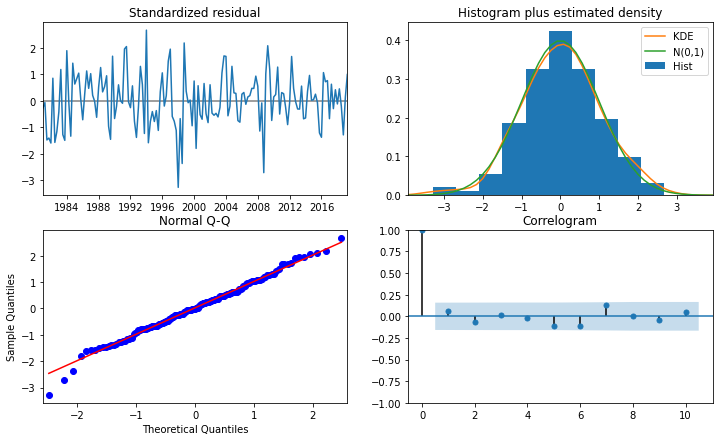

In [27]:
# seasonal ARIMA(1,1,0)×(0,1,1)_4
param = (1, 0, 0, 1) 
d, D = 1, 1
s = 4

model_fit = sm.tsa.statespace.SARIMAX(pp, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)

model_fit.plot_diagnostics(figsize=(12,7))
plt.show()

In [28]:
# Shapiro-Wilk Normality Test
shapiro_test = scs.shapiro(model_fit.resid)
print("Test statistics: {:.4f}".format(shapiro_test[0]))
print("P-value: {:.4f}".format(shapiro_test[1]))

Test statistics: 0.1458
P-value: 0.0000


In [29]:
# Ljung-Box Test
no_lags = 10
critical_val = 0.05
lb_stat, pval = sm.stats.acorr_ljungbox(model_fit.resid, lags=no_lags)
lb_res = pd.DataFrame({"lb_stat": lb_stat, "lb_pvalue": pval}, index=np.arange(1, no_lags + 1))
lb_res["Sig?"] = lb_res['lb_pvalue'] < critical_val
lb_res

,lb_stat,lb_pvalue,Sig?
1,0.006920,0.933702,False
2,0.006925,0.996544,False
3,0.028576,0.998726,False
4,24.553452,0.000062,True
5,24.554183,0.000170,True
6,24.557215,0.000412,True
7,24.562203,0.000907,True
8,24.570798,0.001837,True
9,24.588504,0.003462,True
10,24.589232,0.006181,True


Still, normality is not satisfied and the residuals are correlated. We then conduct a grid search of parameters and explore if there are models with better AIC results.

#### II-2-d. Analysis of Over-parameterized Models

In [30]:
# setting initial values and some bounds for them
ps = range(0, 5)
d=1 
qs = range(0, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 4 

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [31]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(pp, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [32]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)


CPU times: user 1min 43s, sys: 1min 15s, total: 2min 58s
Wall time: 1min 32s


In [33]:
result_table.head()

,parameters,aic
0,"(1, 0, 0, 1)",-779.307807
1,"(2, 0, 0, 1)",-778.549235
2,"(1, 0, 1, 1)",-777.464011
3,"(2, 3, 0, 1)",-776.870580
4,"(2, 1, 0, 1)",-776.791795


Note that the best model (measured by AIC) is still $ARIMA(1,1,0)×(0,1,1)_4$, which has been investigated above. Both its problematic diagnostics and complexity make it an inferior candidate, compared to the non-seasonal candidate. Therefore, we **finalize the model to be $ARIMA(1,1,0)$**.

### II-3 Forecasting

In [64]:
param = (1, 1, 0) # ARIMA(1,1,0)
best_model_fit = ARIMA(pp, order=param).fit(method='css-mle')
forecasts, se, conf_int = best_model_fit.forecast(steps=5, alpha=0.05)

Since the predicted values & intervals are based on the transformed series. We need to transform them back: this preserves the coverage of the prediction intervals, and the back-transformed point forecast can be considered the median of the forecast densities (assuming the forecast densities on the transformed scale are symmetric) [[see here]](https://robjhyndman.com/hyndsight/backtransforming/)

In [65]:
forecasts_ori = sps.inv_boxcox(forecasts, fitted_lambda)
conf_int_ori = sps.inv_boxcox(conf_int, fitted_lambda)

# connect the line of forecasts to actual
endpoint = price.iloc[-6].values[0]
forecasts_ori_ = np.insert(forecasts_ori, 0, endpoint)
conf_int_ori_ = np.vstack([[endpoint, endpoint], conf_int_ori])

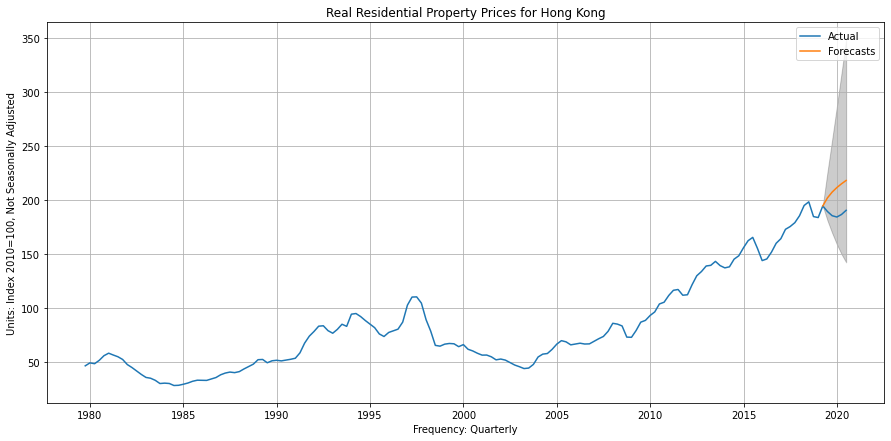

In [66]:
fig, ax = plt.subplots(1, figsize=(15, 7))

ax.plot(price[:].QHKR628BIS, label='Actual')
ax.plot(price[-6:].index, forecasts_ori_, label='Forecasts')
ax.fill_between(price[-6:].index,
                conf_int_ori_[:, 0],
                conf_int_ori_[:, 1], color='k', alpha=.2)

plt.title('Real Residential Property Prices for Hong Kong')
plt.grid(True)
plt.xlabel("Frequency: Quarterly")
plt.ylabel("Units: Index 2010=100, Not Seasonally Adjusted")
plt.legend()
plt.show()

In [67]:
mse = ((forecasts_ori - price[-5:].QHKR628BIS.values) ** 2).mean()
print('The Mean Squared Error of out-of-sample forecasts: {}'.format(round(mse, 2)))


mape = mean_absolute_percentage_error(forecasts_ori, price[-5:].QHKR628BIS.values)
print("Mean Absolute Percentage Error of out-of-sample forecasts: {0:.2f}%".format(mape))

The Mean Squared Error of out-of-sample forecasts: 589.37
Mean Absolute Percentage Error of out-of-sample forecasts: 11.09%


## III. Deterministic Trends & Exponential Smoothing

### III-1. Moving Average
Assume that the future value of our variable depends on the average of its  k  previous values.

In [78]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(price, 4) # prediction based on last 4 quarters

186.974825

In [82]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

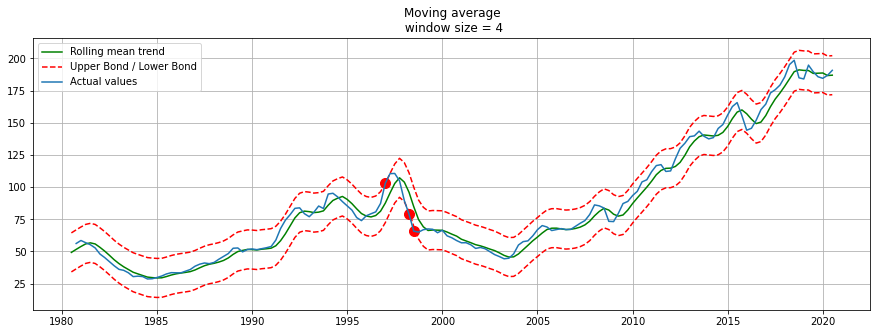

In [88]:
# smooth by the previous 4 quarters
plotMovingAverage(price, 4, plot_intervals=True, plot_anomalies=True) 

We detected 3 anomaly points using simple moving average. It makes sense because during the Asian financial crisis, property prices in Hong Kong dropped sharply by close to 50% between
the last quarter of 1997 and the last quarter of 2000 [[HKMA]](https://www.hkma.gov.hk/media/eng/publication-and-research/quarterly-bulletin/qb200105/fa02.pdf)




A more general model is the Weighted Average.

In [89]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

weighted_average(price, [0.6, 0.3, 0.1])

188.96344

### III-2. Exponential Smoothing
We start weighting all available observations while exponentially decreasing the weights as we move further back in time. <br>
The $\alpha$ below indicates how quickly we will "forget" the last available true observation. The smaller $\alpha$ is, the more influence the previous observations have and the smoother the series is.

In [90]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

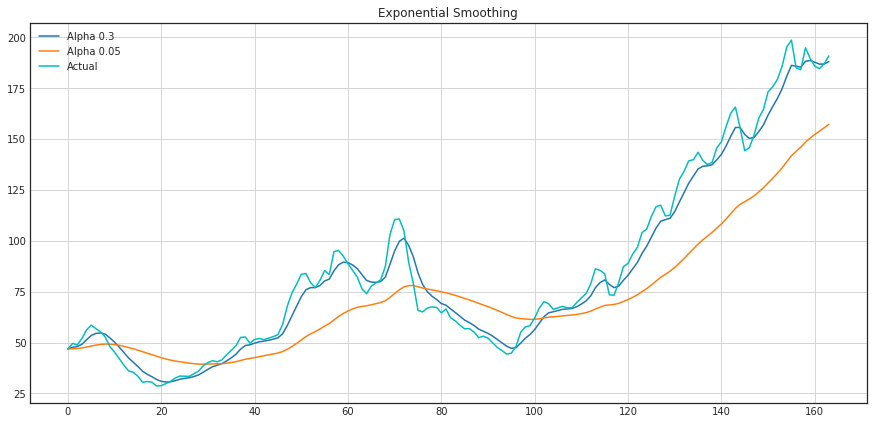

In [92]:
plotExponentialSmoothing(price.QHKR628BIS, [0.3, 0.05])

### III-3. Double Exponential Smoothing
Series decomposition: intercept (i.e. level)  ℓ  and slope (i.e. trend)  b . We have predicted intercept (or expected series value) above; Then we apply the same exponential smoothing to the trend by assuming that the future direction of the time series changes depends on the previous weighted changes.

In [93]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        # intercept depends on the current value of the series
        # second term is split into previous values of the level and of the trend
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        # trend depends on the level changes at the current step and on the previous value of the trend
        trend = beta*(level-last_level) + (1-beta)*trend
        # final prediction is the sum of the model values of the intercept and trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

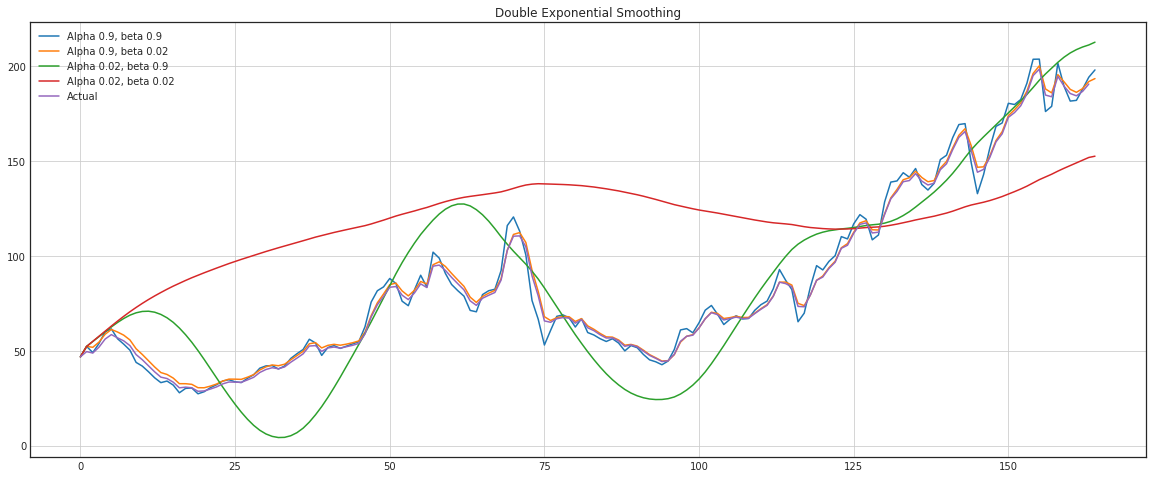

In [94]:
plotDoubleExponentialSmoothing(price.QHKR628BIS, alphas=[0.9, 0.02], betas=[0.9, 0.02])

### III-4. Triple exponential smoothing (Holt-Winters)
A third component, seasonality, is incorporated. See more [here](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm)

In [95]:
class HoltWinters:
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    """
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

#### III-4-a. Parameter Selection - Cross Validation
Time-series (or other intrinsically ordered data) can be problematic for cross-validation. We use the following way to achieve our goal [[here]](https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection):
*  fold 1 : training [1], test [2]
*  fold 2 : training [1 2], test [3]
*  fold 3 : training [1 2 3], test [4]
*  fold 4 : training [1 2 3 4], test [5]
*  fold 5 : training [1 2 3 4 5], test [6]

In [96]:
from sklearn.model_selection import TimeSeriesSplit

# slen set to 4 b/c quarterly
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=4):
    """
        Returns error on CV  
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

The optimization algorithm here is chosen to be truncated Newton conjugate gradient, which can deal with the constraints on parameters (i.e. ranging from 0 to 1)

In [149]:
%%time
data = price[:-10].QHKR628BIS # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# Train the model with them, forecasting for the next 20 quarters
model = HoltWinters(data, slen = 4, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 20, scaling_factor = 3)
model.triple_exponential_smoothing()

0.24147240012242388 0.05816643841464414 1.0
CPU times: user 1.76 s, sys: 23.7 ms, total: 1.79 s
Wall time: 1.77 s


In [152]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    plt.figure(figsize=(15, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-10, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

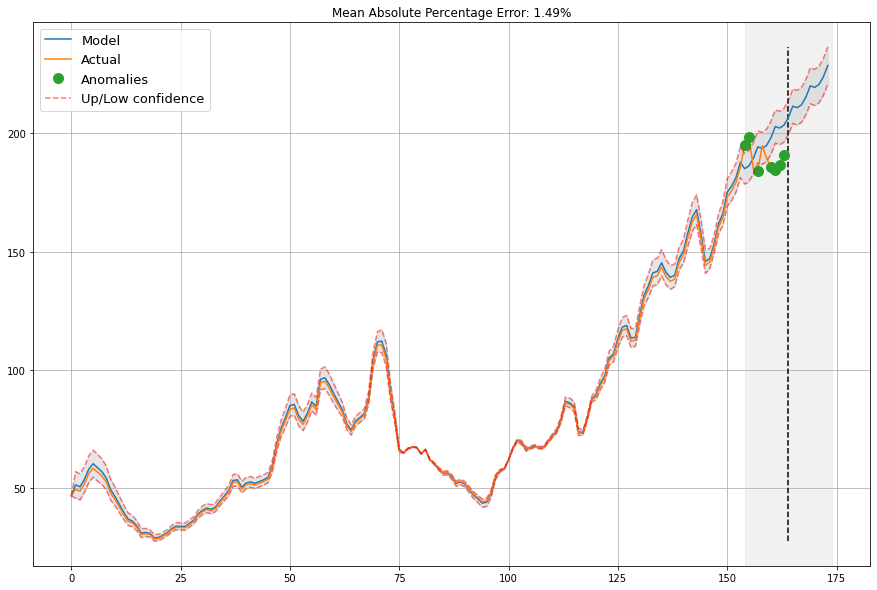

In [153]:
plotHoltWinters(price.QHKR628BIS, plot_intervals=True, plot_anomalies=True)

No anomaly was detected within the training set and it doesn't perform well in the test set - potentially overfitting. Perhaps the seasonality is not so strong and thus Holt-Winters model doesn't work well.

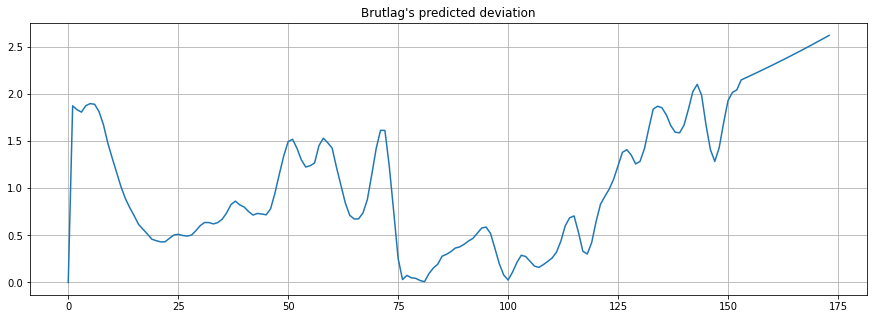

In [156]:
plt.figure(figsize=(15, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

## IV. Machine Learning Approach

### IV-1. Feature Extraction

#### IV-1-a. Time Series Lags
Shifting the series  $n$  steps back, we get a feature column where the current value of time series is aligned with its value at time  $t−n$. If we make a 1 lag shift and train a model on that feature, the model will be able to forecast 1 step ahead from having observed the current state of the series.

In [51]:
# Creating a copy of the initial dataframe to make various transformations 
data = pd.DataFrame(price.QHKR628BIS.copy())
data.columns = ["y"]

In [52]:
# Adding the lag of the target variable from 1 steps back up to 8
for i in range(1, 9):
    data["lag_{}".format(i)] = data.y.shift(i)
data.tail()

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8
DATE,,,,,,,,,
2019-07-01,189.6312,194.7993,184.0334,184.9253,198.5813,195.1955,185.7266,179.2883,175.6970
2019-10-01,185.7465,189.6312,194.7993,184.0334,184.9253,198.5813,195.1955,185.7266,179.2883
2020-01-01,184.5346,185.7465,189.6312,194.7993,184.0334,184.9253,198.5813,195.1955,185.7266
2020-04-01,186.8698,184.5346,185.7465,189.6312,194.7993,184.0334,184.9253,198.5813,195.1955
2020-07-01,190.7484,186.8698,184.5346,185.7465,189.6312,194.7993,184.0334,184.9253,198.5813


Then we train a model.

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [54]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [55]:
# a simple ML algo: linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

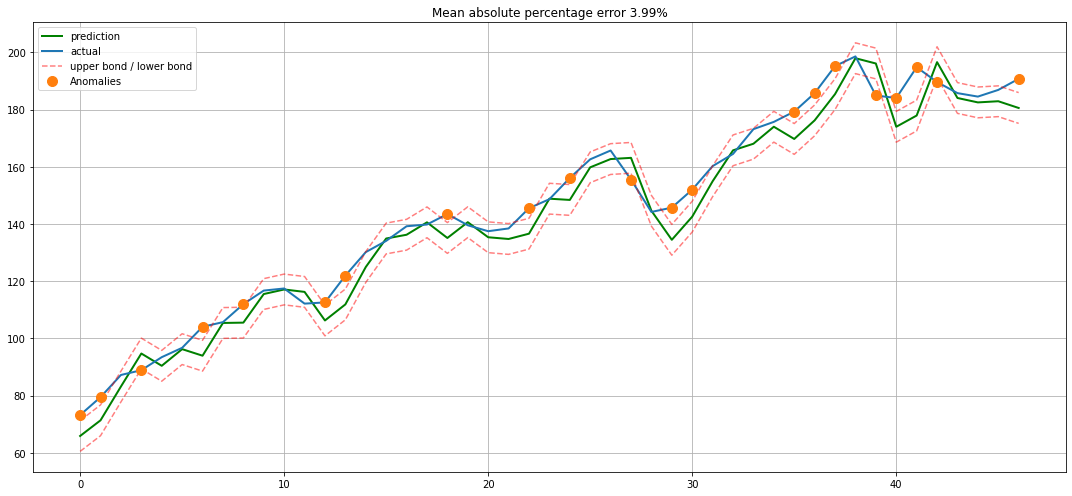

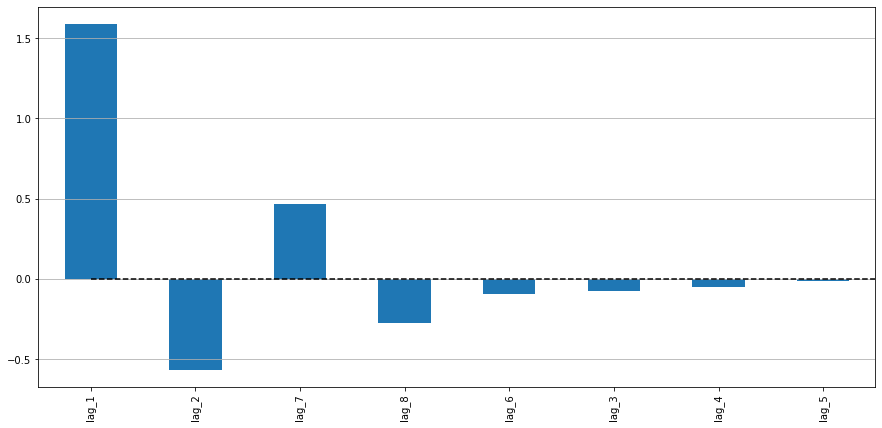

In [60]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    """
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

plotModelResults(lr, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

We could potentially consider more features as follows:
*  Lags of time series
*  Window statistics:
  *  Max/min value of series in a window
  *  Average/median value in a window
  *  Window variance
*  Date and time features:
  *  Minute of an hour, hour of a day, day of the week, and so on
  *  Is this day a holiday? Maybe there is a special event? Represent that as a boolean feature
*  Target encoding
*  Forecasts from other models

Target encoding: to encode with the mean value of the target variable. For example, every day of the week and every hour of the day can be encoded by the corresponding average number during that day or hour. Important to make sure that the mean value is calculated over the training set only (or over the current cross-validation fold only) so that the model is not aware of the future.

### IV-2. Regularization and Feature Selection

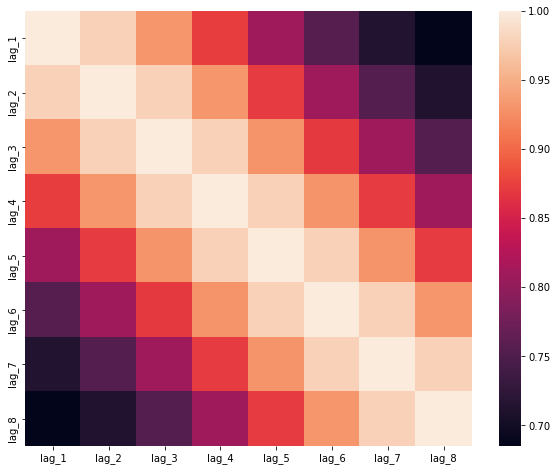

In [57]:
# heatmap visualizes highly correlated features
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

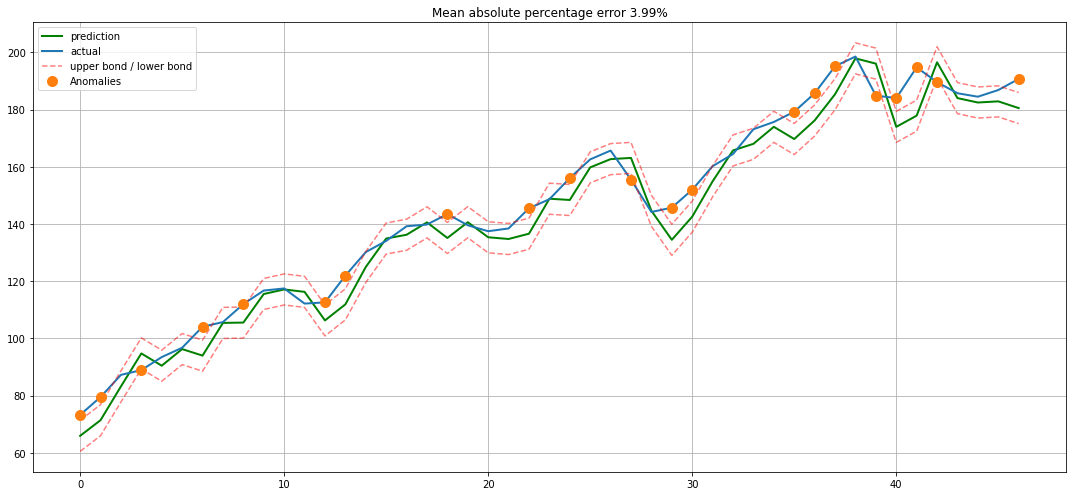

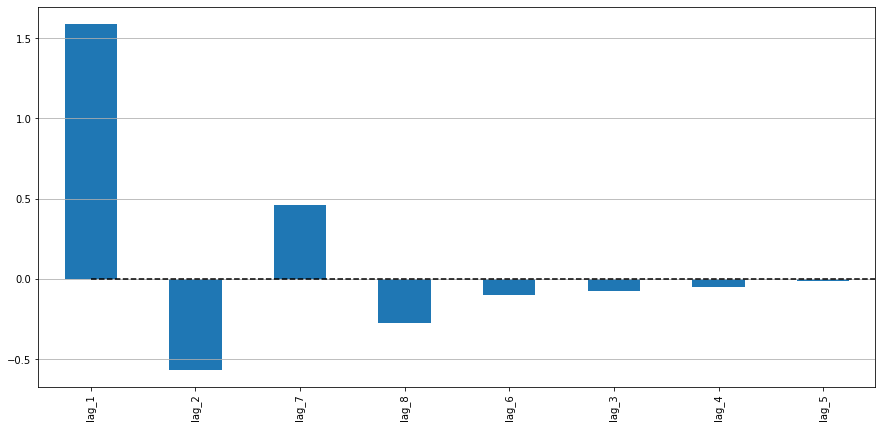

In [59]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train, y_train)

plotModelResults(ridge, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

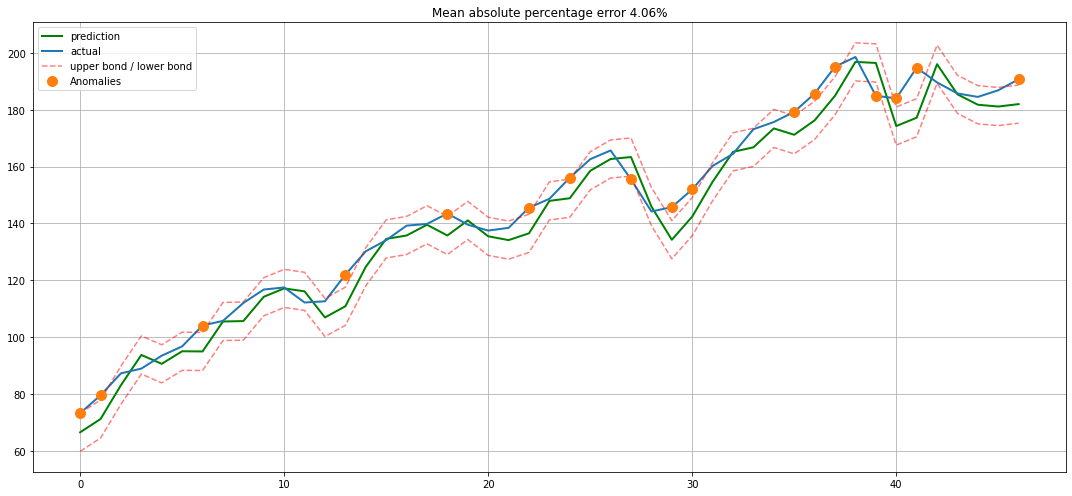

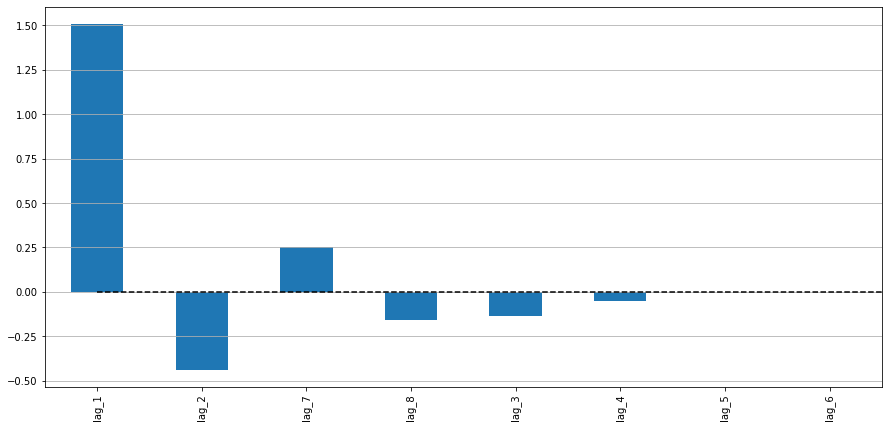

In [62]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train, y_train)

plotModelResults(lasso, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

Ridge regression didn't change the result much while Lasso forced 2 insignificant coefficients to become zero.

### IV-3. More algos: XGBoost

In [72]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train, y_train)

[02:56:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

[02:56:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:56:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:56:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:56:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:56:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


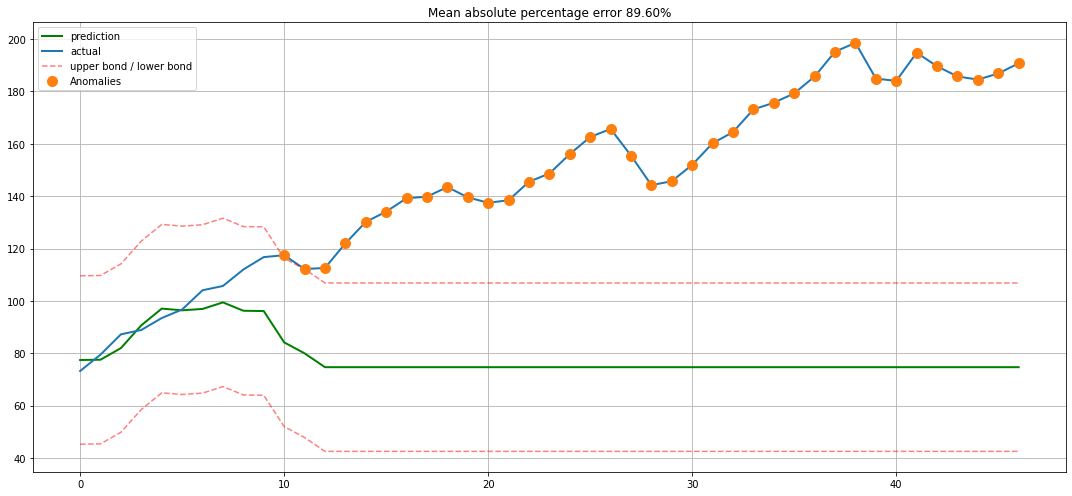

In [73]:
plotModelResults(xgb, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)

Generally, tree-based models handle trends in data poorly when compared with linear models. So we need to detrend the series first. Ideally, we can make the series stationary and then use XGBoost.

## V. Facebook Prophet

At its core, the Prophet procedure is an additive regression model with four main components:

*  A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
*  A yearly seasonal component modeled using Fourier series.
*  A weekly seasonal component using dummy variables.
*  A user-provided list of important holidays.

Read more [here](https://research.fb.com/prophet-forecasting-at-scale/)

In [79]:
from fbprophet import Prophet

import logging
logging.getLogger().setLevel(logging.ERROR)

In [80]:
# convert our dataframe to the format required by Prophet
df = price.reset_index()
df.columns = ['ds', 'y']
df.tail(n=3)

,ds,y
161,2020-01-01,184.5346
162,2020-04-01,186.8698
163,2020-07-01,190.7484


In [81]:
# remove the last 5 quarters in order to use it later as a prediction target
prediction_size = 5
train_df = df[:-prediction_size]
train_df.tail(n=3)

,ds,y
156,2018-10-01,184.9253
157,2019-01-01,184.0334
158,2019-04-01,194.7993


In [82]:
m = Prophet()
m.fit(train_df);

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [104]:
future = m.make_future_dataframe(periods=prediction_size)
forecast = m.predict(future)
# since the last 5 timestamps were confused to be daily, we correct it here
forecast['ds'] = df['ds']
forecast.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
161,2020-01-01,196.240201,178.381901,209.660436,196.240201,196.240201,-2.276749,-2.276749,-2.276749,-2.276749,-2.276749,-2.276749,0.0,0.0,0.0,193.963452
162,2020-04-01,196.266619,178.680429,210.942784,196.266619,196.266619,-0.516858,-0.516858,-0.516858,-0.516858,-0.516858,-0.516858,0.0,0.0,0.0,195.749761
163,2020-07-01,196.293036,181.730341,214.262271,196.293036,196.293036,1.179411,1.179411,1.179411,1.179411,1.179411,1.179411,0.0,0.0,0.0,197.472447


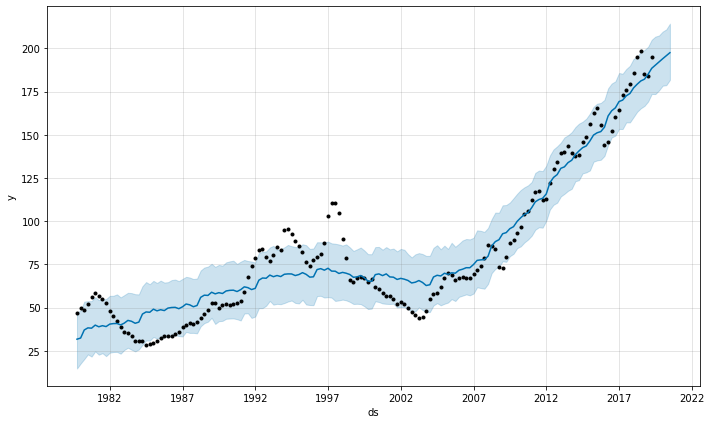

In [105]:
m.plot(forecast);

The model treated many of the data points as outliers, especially those around Asian financial crisis. In the 2010s we can see clearly the steady growth of housing price.

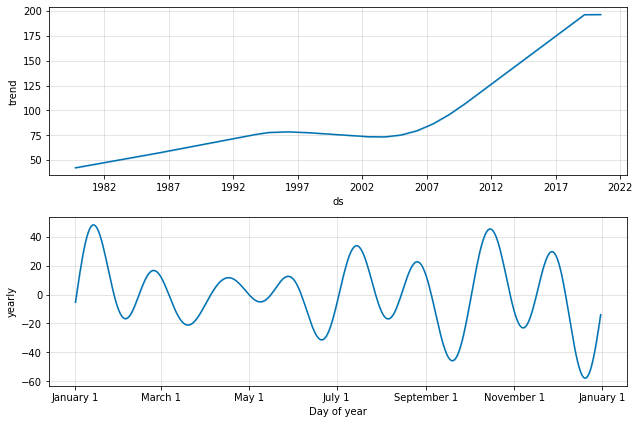

In [106]:
# observe different components of the model separately: trend, yearly and weekly seasonality
m.plot_components(forecast);

The yearly seasonality shows that property prices drop during Christmast but would rise after New Year.

In [107]:
# see what columns are available
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


In [108]:
def make_comparison_dataframe(historical, forecast):
    """
       Join the history with the forecast.
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.tail(n=3)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2020-01-01,193.963452,178.381901,209.660436,184.5346
2020-04-01,195.749761,178.680429,210.942784,186.8698
2020-07-01,197.472447,181.730341,214.262271,190.7484


In [112]:
def calculate_forecast_errors(df, prediction_size):
    """
       Calculate MAPE and MAE of the forecast.
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    # Make a copy
    df = df.copy()
    
    # calculate MAPE
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 3.4332497160248883
MAE 6.413349709345272


MAPE is 3.43% and on average the model is wrong by 6.41 units of price (MAE).